In [128]:
import numpy as np
import pandas as pd
import datetime as dt
import re
from nltk.util import ngrams

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
CB91_Blue = '#1f77b4'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#ff7f0e'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [129]:
customer = pd.read_csv('./Data/QVI_purchase_behaviour.csv')
dat = pd.read_excel('./Data/QVI_transaction_data.xlsx')

customer.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [130]:
# check for missing values
customer.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [131]:
dat.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [132]:
dat.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [133]:
# Change excel date to real date
dat['DATE'] = pd.TimedeltaIndex(dat['DATE'], unit='d') + dt.datetime(1899, 12, 30)

In [134]:
dat.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
5,2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
6,2019-05-16,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,2019-05-16,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,2018-08-20,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,2018-08-18,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2


In [135]:
# Extract product size
dat['PROD_SIZE'] = [re.search(r"[0-9]+(g|G)", p).group(0).replace('G','').replace('g','') for p in dat['PROD_NAME']]


Some of the products are not chips, most of them with the word **'Salsa'**. However, some salsa are actually chips with 'salsa' in their product names. We will need to remove those that are salsa and not chips.

In [136]:
# get unique products
dat['PROD_NAME'].unique() 

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [137]:
### Remove salsa dips
dat = dat[~dat['PROD_NAME'].isin(['Old El Paso Salsa   Dip Tomato Mild 300g',
'Old El Paso Salsa   Dip Chnky Tom Ht300g',
'Woolworths Mild     Salsa 300g',
'Old El Paso Salsa   Dip Tomato Med 300g',
'Woolworths Medium   Salsa 300g',
'Doritos Salsa Mild  300g',
'Doritos Salsa       Medium 300g'])].reset_index(drop=True)

In [138]:
### Clean up product names
# https://www.guru99.com/python-regular-expressions-complete-tutorial.html

# replace & with space and remove multiple spaces
dat['PROD_NAME'] = [" ".join(p.replace('&',' ').split()) for p in dat['PROD_NAME']]
# remove digits that are followed by grams
dat['PROD_NAME'] = [re.sub(r"\s*[0-9]+(g|G)", r"", p) for p in dat['PROD_NAME']]


In [139]:
def replaceWords(string):
    # specific
    string = re.sub(r"SeaSalt", "Sea Salt", string)
    string = re.sub(r"Frch/Onin", "French Onion", string)
    string = re.sub(r"Cheddr Mstrd", "Cheddar Mustard", string)
    string = re.sub(r"Jlpno Chili", "Jalapeno Chilli", string)
    string = re.sub(r"Swt/Chlli Sr/Cream", "Sweet Chilli Sour Cream", string)
    string = re.sub(r"SourCream", "Sour Cream", string)
    string = re.sub(r"Tmato Hrb Spce", "Tomato Herb Spice", string)
    string = re.sub(r"S/Cream", "Sour Cream", string)
    string = re.sub(r"ChipsFeta", "Chips Feta", string)
    string = re.sub(r"ChpsHny", "Chips Honey", string)
    string = re.sub(r"FriedChicken", "Fried Chicken", string)
    string = re.sub(r"OnionDip", "Onion Dip", string)
    string = re.sub(r"SweetChili", "Sweet Chilli", string)
    string = re.sub(r"PotatoMix", "Potato Mix", string)
    string = re.sub(r"Seasonedchicken", "Seasoned Chicken", string)
    string = re.sub(r"CutSalt/Vinegr", "Cut Salt Vinegar", string)
    string = re.sub(r"ChpsBtroot", "Chips Beetroot", string)
    string = re.sub(r"ChipsBeetroot", "Chips Beetroot", string)
    string = re.sub(r"ChpsFeta", "Chips Feta", string)
    string = re.sub(r"OnionStacked", "Onion Stacked", string)
    string = re.sub(r"Ched", "Cheddar", string)
    string = re.sub(r"Strws", "Straws", string)
    string = re.sub(r"Slt", "Salt", string)
    string = re.sub(r"Chikn", "Chicken", string)
    string = re.sub(r"Rst", "Roast", string)
    string = re.sub(r"Vinegr", "Vinegar", string)
    string = re.sub(r"Mzzrlla", "Mozzarella", string)
    string = re.sub(r"Originl", "Original", string)
    string = re.sub(r"saltd", "Salted", string)
    string = re.sub(r"Swt", "Sweet", string)
    string = re.sub(r"Chli", "Chilli", string)
    string = re.sub(r"Hony", "Honey", string)
    string = re.sub(r"Chckn", "Chicken", string)
    string = re.sub(r"Chp", "Chip", string)
    string = re.sub(r"Btroot", "Beetroot", string)
    string = re.sub(r"Chs", "Cheese", string)
    string = re.sub(r"Crm", "Cream", string)
    string = re.sub(r"Orgnl", "Original", string)

    return string

dat['PROD_NAME'] = [replaceWords(s) for s in dat['PROD_NAME']]

dat['PROD_NAME'].replace('Infzns Crn Crnchers Tangy Gcamole',
'Infuzions Corn Crunchers Tangy Guacamole', inplace=True)

In [140]:
dat['PROD_NAME'].unique()[:10]

array(['Natural Chip Compny Sea Salt', 'CCs Nacho Cheese',
       'Smiths Crinkle Cut Chips Chicken',
       'Smiths Chip Thinly Sour Cream Onion',
       'Kettle Tortilla Chips Honey Jalapeno Chilli',
       'Smiths Crinkle Chips Salt Vinegar', 'Grain Waves Sweet Chilli',
       'Doritos Corn Chip Mexican Jalapeno',
       'Grain Waves Sour Cream Chives', 'Kettle Sensations Siracha Lime'],
      dtype=object)

In [141]:
def replaceBrands(string):
    # specific
    string = re.sub(r"Red Rock Deli", "RRD", string)
    string = re.sub(r"Dorito", "Doritos", string)
    string = re.sub(r"Doritoss", "Doritos", string)
    string = re.sub(r"Smith", "Smiths", string)
    string = re.sub(r"Smithss", "Smiths", string)
    string = re.sub(r"GrnWves", "Grain Waves", string)
    string = re.sub(r"Woolworths", "WW", string) 
    string = re.sub(r"Snbts", "Sunbites", string) 

    return string

# standardize common brand names
dat['PROD_NAME'] = [replaceBrands(s) for s in dat['PROD_NAME']]

# get brand name from first word
dat['brand'] = [s.split(' ')[0] for s in dat['PROD_NAME']]

In [142]:
dat.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE,brand
0,2018-10-17,1,1000,1,5,Natural Chip Compny Sea Salt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly Sour Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chips Honey Jalapeno Chilli,3,13.8,150,Kettle


In [143]:
dat.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,249670.000000,2.496700e+05,2.496700e+05,249670.000000,249670.000000,249670.000000
mean,135.044278,1.355203e+05,1.351234e+05,56.294288,1.907762,7.293966
std,76.773591,8.065746e+04,7.813155e+04,33.528758,0.657126,3.071796
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001625e+04,6.757425e+04,27.000000,2.000000,5.700000
50%,130.000000,1.303600e+05,1.351475e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030798e+05,2.026338e+05,86.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [144]:
# remove outlier
dat = dat[dat['PROD_QTY'] < 200].reset_index(drop=True)

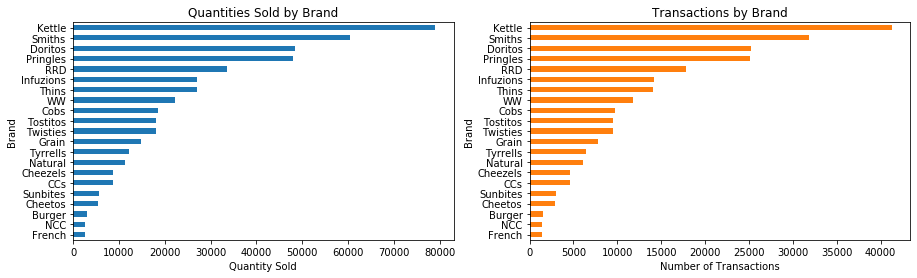

In [197]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# Product quantity sales by brand
ax1=plt.subplot(121)
dat.groupby(['brand'], as_index=False).agg({'PROD_QTY': 'sum'}).sort_values('PROD_QTY').plot.barh(x='brand',legend=False, ax=ax1)

ax1.set_xlabel('Quantity Sold')
ax1.set_ylabel('Brand')
ax1.set_title('Quantities Sold by Brand')

ax2=plt.subplot(122)
dat.groupby(['brand'], as_index=False)[['TXN_ID']].count().sort_values('TXN_ID').plot.barh(x='brand',color=CB91_Amber, legend=False, ax=ax2)
ax2.set_xlabel('Number of Transactions')
ax2.set_ylabel('Brand')
ax2.set_title('Transactions by Brand')

plt.show()

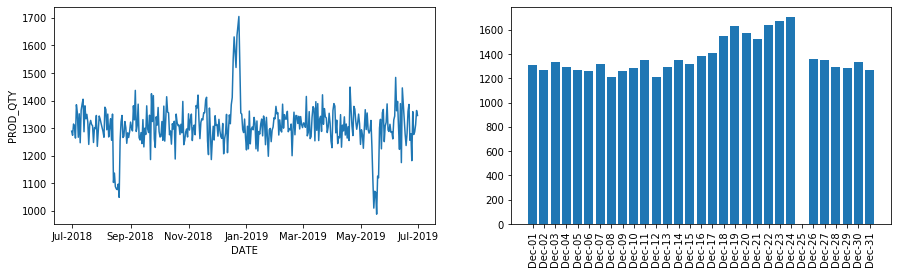

In [146]:
## Plot quantities sold by date
bydate = dat.groupby('DATE').agg({'PROD_QTY': 'sum'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

ax1=plt.subplot(121)
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate, ax=ax1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))


## Plot December quantities sold
# filter december
december = bydate[bydate['DATE'].isin(pd.date_range(start="2018-12-01",end="2018-12-31").tolist())]

# fill in missing dec data
december = december.set_index('DATE').reindex(pd.date_range(start="2018-12-01",end="2018-12-31"), fill_value=0)

ax2=plt.subplot(122)
ax2.bar(december.index,december['PROD_QTY'])
ax2.set_xticks(december.index)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%d"))
ax2.tick_params(axis='x', rotation=90) 
plt.show()

In [147]:
dat.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE,brand
0,2018-10-17,1,1000,1,5,Natural Chip Compny Sea Salt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly Sour Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chips Honey Jalapeno Chilli,3,13.8,150,Kettle
5,2019-05-16,4,4149,3333,16,Smiths Crinkle Chips Salt Vinegar,1,5.7,330,Smiths
6,2019-05-16,4,4196,3539,24,Grain Waves Sweet Chilli,1,3.6,210,Grain
7,2018-08-20,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno,1,3.9,150,Doritos
8,2018-08-18,7,7150,6900,52,Grain Waves Sour Cream Chives,2,7.2,210,Grain
9,2019-05-17,7,7215,7176,16,Smiths Crinkle Chips Salt Vinegar,1,5.7,330,Smiths


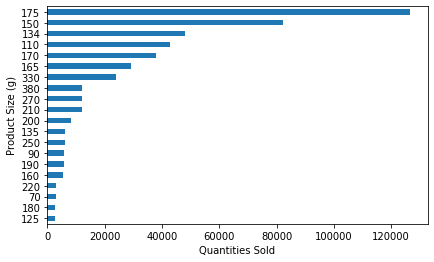

In [148]:
# Product Size

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

ax1=plt.subplot(121)
dat.groupby('PROD_SIZE').agg({'PROD_QTY': 'sum'}).sort_values('PROD_QTY').reset_index().plot.barh(x='PROD_SIZE', legend=False, ax=ax1)
ax1.set_ylabel('Product Size (g)')
ax1.set_xlabel('Quantities Sold')

plt.show()

In [174]:
def count_keywords(df):
    words_freq = {}
    for c,p in enumerate(df['PROD_NAME']):
        for word in p.split():
            if word in words_freq:
                words_freq[word] += df['PROD_QTY'][c]
            else:
                words_freq[word] = df['PROD_QTY'][c]
    
    return words_freq

def generate_ngrams(text, n):
    words = text.split()
    return [' '.join(ngram) for ngram in list(ngrams(words, n))]

def count_bigrams(df):
    bigrams_freq = {}
    for c,p in enumerate(df['PROD_NAME']):
        for ngram in generate_ngrams(p, 2):
            if ngram in bigrams_freq:
                bigrams_freq[ngram] += df['PROD_QTY'][c]
            else:
                bigrams_freq[ngram] = df['PROD_QTY'][c]
    return bigrams_freq

In [252]:
words_freq = count_keywords(dat)
bigrams_freq = count_bigrams(dat)

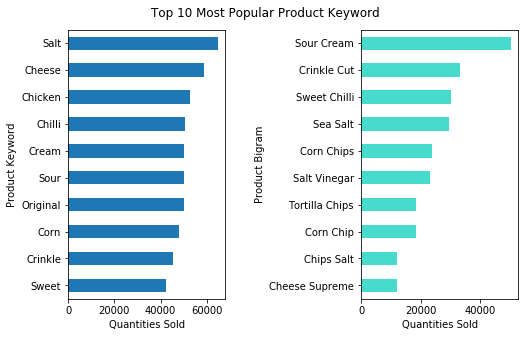

In [195]:
topwords = pd.DataFrame(words_freq.items(), columns=['word','freq']).sort_values('freq')
topwords = topwords[~topwords.word.isin(['Chips','Kettle','Smiths','Doritos','Pringles'])]

topbigrams = pd.DataFrame(bigrams_freq.items(), columns=['bigram','freq']).sort_values('freq')
topbigrams = topbigrams[~topbigrams.bigram.isin(['Smiths Crinkle','Doritos Corn','Thins Chips','Cobs Popd','Kettle Tortilla','Grain Waves','Kettle Sensations','Kettle Sweet','Tyrrells Crisps','Twisties Cheese'])]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))

ax1 = plt.subplot(121)
topwords[-10:].plot.barh(x='word', legend=False, ax=ax1)
ax1.set_xlabel('Quantities Sold')
ax1.set_ylabel('Product Keyword')

ax2 = plt.subplot(122)
topbigrams[-10:].plot.barh(x='bigram', color=CB91_Green, legend=False, ax=ax2)
ax2.set_xlabel('Quantities Sold')
ax2.set_ylabel('Product Bigram')

fig.tight_layout(pad=3.0)
plt.suptitle('Top 10 Most Popular Product Keywords')
plt.show()

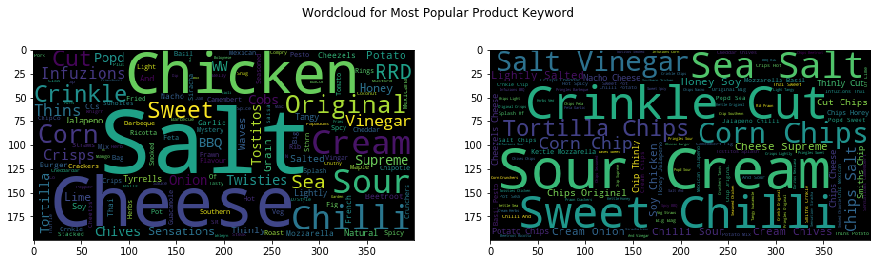

In [253]:
from wordcloud import WordCloud

rem_list = ['Chips','Kettle','Smiths','Doritos','Pringles','Chip']
[words_freq.pop(key) for key in rem_list] 

rem_list = ['Smiths Crinkle','Doritos Corn','Thins Chips','Cobs Popd','Kettle Tortilla','Grain Waves','Kettle Sensations','Kettle Sweet','Tyrrells Crisps','Twisties Cheese']
[bigrams_freq.pop(key) for key in rem_list] 

plt.figure(figsize=(15,4))
plt.subplot(121)
wc = WordCloud(background_color="black").generate_from_frequencies(words_freq)
plt.imshow(wc)
plt.subplot(122)
wc = WordCloud(background_color="black").generate_from_frequencies(bigrams_freq)
plt.imshow(wc)
plt.suptitle('Most Popular Product Keywords')
plt.show()

In [231]:
customer.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [232]:
customer.LIFESTAGE.unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [233]:
customer['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)